## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [2]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [3]:
calculate = Calculate('100_pop.geojson', 'A_com.geojson', 0.489773)
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [4]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]
#売場面積の取得
com_areaList = [i['properties']['売場面積'] for i in com['features']]
#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#売り上げを取得
com_saleList = np.array([i['properties']['年間商品販売額(百万円)'] for i in com['features']])
#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

#idを作成
id = [i for i in range(len(com_areaList))]

## 比例定数の算出
- 売上高/人口 = k(円/人)

In [5]:
popSum = np.sum(pop_popList)
saleSum = np.sum(com_saleList)
k = 2956541 / popSum*0.37
k

0.485898751112213

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数
- @param k: 係数

In [6]:
area = 0.9
dist = 1.4

## 売上高の予測

In [7]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist)

100%|██████████| 32564/32564 [01:10<00:00, 463.18it/s]


In [8]:
predictList*k

array([ 11591.43480031,   3633.83460884,   2255.49841027,   2693.68470769,
         4176.3984461 ,  32514.22537687,   3799.68097765,   2346.63989567,
        22959.96078177,  14469.96058865,   1777.53569123,   2747.5403675 ,
         1365.62576447,   2095.71630777,  32702.77890019,   1881.17189167,
         2442.62828178,   1871.01230492,   2311.83266077,   2330.72244755,
        12753.43533765,  14561.67398223,   2128.61720946,   1578.26031239,
        31439.02707879,  10731.00131875,   8910.93528805,   3838.33792523,
        10342.9127725 ,  42381.7354355 ,   1249.07813293,   3086.62752231,
        16756.75284365,   2201.0332971 ,   3198.11844648,  30555.76548048,
         1681.94326953,   2707.6014868 ,   2523.91420872, 104071.30006646,
         1753.13379903,   2148.13811996,   4031.65392196,   2606.60774606,
         1337.8382666 ,   7071.43267994,   3265.7188179 ,   4834.12764972,
         1824.04034932,   1376.88043285,   2128.92624557,   1655.34952784,
         9272.02166543,  

(array([129.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.290000e+02, 2.713470e+04, 5.414040e+04, 8.114610e+04,
        1.081518e+05, 1.351575e+05, 1.621632e+05, 1.891689e+05,
        2.161746e+05, 2.431803e+05, 2.701860e+05]),
 <a list of 10 Patch objects>)

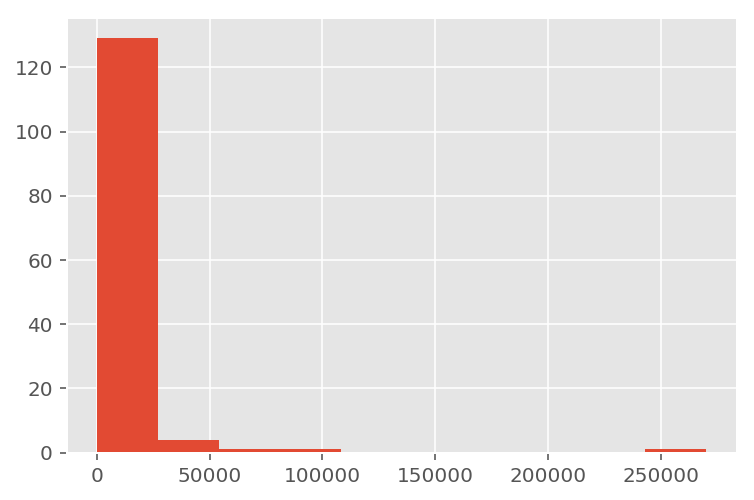

In [9]:
plt.hist(com_saleList)

In [10]:
com_saleList

array([  5312,   1457,    889,   3868,   2638,  31499,    960,    968,
        12089,  10006,    577,   1830,    835,   1955,  24340,   2755,
         2426,    825,   1593,    938,   5707,   6520,   1009,    835,
        38308,   5748,   4248,   3436,   6647,  54551,   2899,   4188,
        28689,   7132,   2391,  83263,   2452,   4985,   2227, 270186,
         2952,   2487,   6955,   4694,    643,   8936,   3335,   6998,
          596,   1280,   1290,    560,   5522,   1393,   1615,   2601,
         3698,   2693,   2175,   3974,  15710,   2086,  11617,  23437,
         3262,   6822,  33778,    907,   1387,   1418,   1070,   3381,
        10632,   1227,   4909,   1091,   1600,    347,    479,   2054,
         1137,   2365,   6921,   1424,   4894,  23254,   1605,    202,
         1200,    938,  12814,   4930,  11504,    673,   1499,    693,
          610,    641,   1217,   1313,   9915,  16053,   2955,   2360,
         2230,   3207,   2597,   6438,  10052,   2109,    523,    840,
      

## 残差の計算

In [11]:
e = com_saleList - k*predictList
pd.DataFrame(e)

,0
0,-6279.434800
1,-2176.834609
2,-1366.498410
3,1174.315292
4,-1538.398446
5,-1015.225377
6,-2839.680978
7,-1378.639896
8,-10870.960782
9,-4463.960589


## 平均二乗誤差

In [12]:
RMSE = np.sqrt(np.sum(e**2)/len(com_saleList))
RMSE

15534.512069185883

## 残差プロット

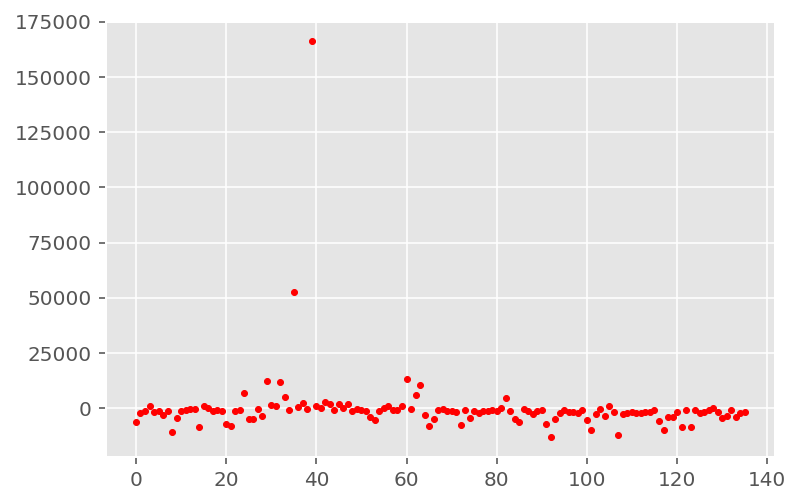

In [13]:
plt.scatter(id, e, c='red', marker='.')

## 理論値売上に対する誤差

In [14]:
sum(e/com_saleList)/136

-0.894505165632778

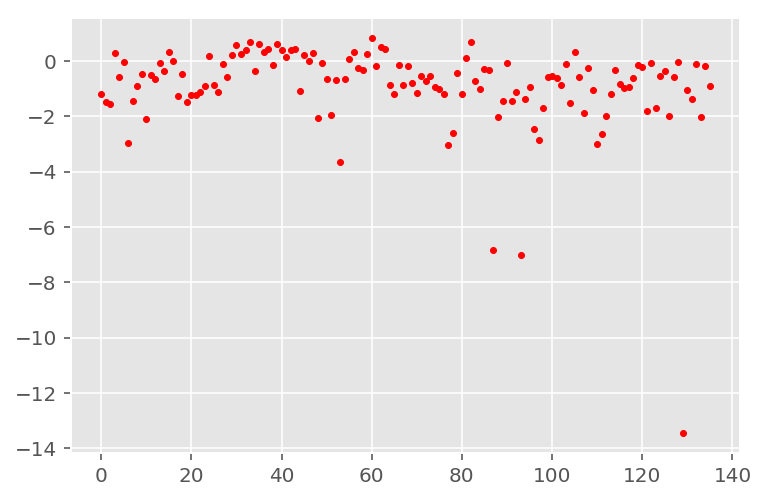

In [15]:
plt.scatter(id, e/com_saleList, c='red', marker='.')

In [16]:
pd.DataFrame({0 : id, 1: e/com_saleList})

,0,1
0,0,-1.182123
1,1,-1.494053
2,2,-1.537119
3,3,0.303598
4,4,-0.583168
5,5,-0.032230
6,6,-2.958001
7,7,-1.424215
8,8,-0.899244
9,9,-0.446128


In [17]:
x = predictList*k

In [18]:
y = com_saleList

In [20]:
np.corrcoef(x,y)

array([[1.        , 0.87945508],
       [0.87945508, 1.        ]])